In [1]:
import matplotlib.pyplot as plt # per i plot
import numpy as np # per manipolazione vettori
from scipy.odr import * # per i fit
from uncertainties import  ufloat
from uncertainties.umath import *
from math import sqrt
%matplotlib notebook

In [2]:
# definizione delle funzioni utili per i calcoli

# definisco la funzione di fit
def fit_function(params, x):
    return params[4]*(params[0]**2 + params[1]**2 + 2*params[0]*params[1]*np.cos(2*params[2]*x + params[3]))

# Calcolo del rapporto d'onda stazionaria
def rapporto_onda_stazionaria(U_F, U_B):
    return (U_F + U_B) / (U_F - U_B)

# Calcolo dell'impedenza del carico
def impedenza_carico(impedenza_guida_onda, U_F, U_B, delta_phi):
    cos_phi = float(cos(delta_phi))
    sin_phi = float(sin(delta_phi))
    real = impedenza_guida_onda * (U_F**2 - U_B**2) / (U_F**2 + U_B**2 - 2*U_F*U_B*cos_phi)
    imaginary = impedenza_guida_onda * (2*U_F*U_B*sin_phi) / (U_F**2 + U_B**2 - 2*U_F*U_B*cos_phi)
    return real, imaginary

def calc_lambda_guida(nu, a, c):
    first = (nu/c)**2
    second = (1/(2*a))**2
    return (first - second)**(-1/2)

# Impedenza e SWR dei vari carichi

* Calcoliamo l'impedenza in guida d'onda 

1. Eseguiamo il fit della funzione
2. Calcoliamo impedenza del carico
3. Calcoliamo il rapporto $SWR$

## Impedenza in guida d'onda

$$
Z_{guida} = Z_0 \frac{\lambda_{guida}}{\lambda_{0}}\frac{2b}{a}
$$

Utilizziamo 
$$
Z_0 = 377 \Omega \qquad \text{impedenza caratteristica del vuoto} \\
a = 2.29 cm \\
b = 1.01 cm \\
\lambda_{guida} = 3.65cm \\
\lambda_{0} = 2.85 cm
$$
Stimiamo gli errori sulla misura della posizione con una precisione di $0.05$mm e l'incertezza sulla tensione di $0.1$V

In [3]:
b = ufloat(0.0101, 0.0005) # cm
a = ufloat(0.0229, 0.0005)
c = 3e8
nu = ufloat(10.5275e9, 0.0001e9)
lambda_guida = calc_lambda_guida(nu, a, c)
lambda_0 = c/nu 
sigma_x = 0.05 # cm
sigma_y = 0.5

Z_g = 377 * lambda_guida / lambda_0 * 2*b/a
Z_g

424.7901035982819+/-25.908583085486036

Da cui otteniamo 
$$
 Z_g  = 425 \pm 26 \Omega
$$

## Fit del carico adattato

Utilizziamo il carico adattato `data_adattato.txt` e lo fittiamo.


<IPython.core.display.Javascript object>


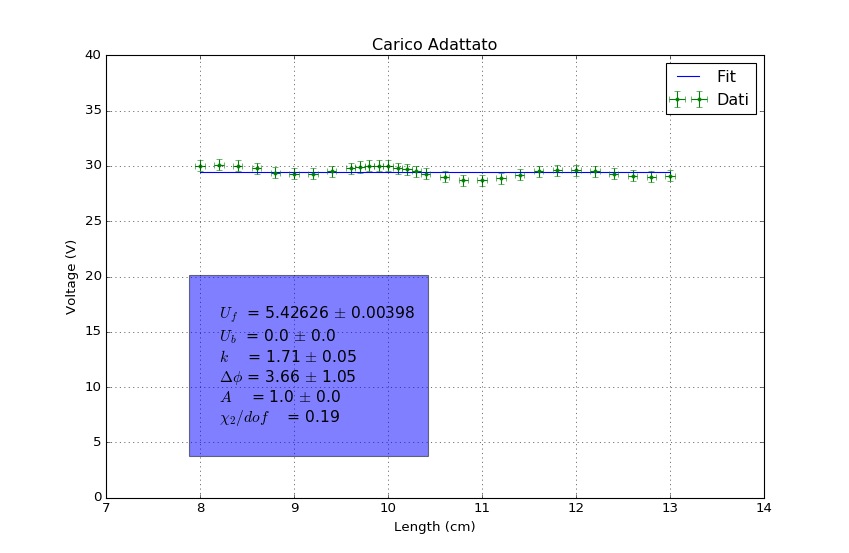

(0.0, 40)

In [8]:
%matplotlib notebook
x_adattato, y_adattato = np.genfromtxt('data_adattato.txt', skip_header=1, unpack=True)

model_adattato = Model(fit_function)
data_adattato = Data(x_adattato, y_adattato, wd=1/sigma_x**2,\
        we=1/sigma_y**2)
myodr = ODR(data_adattato, model_adattato, beta0=[5.33, 0.05, 1.71, 3.14, 1], ifixb=[1, 1, 1, 1, 0])
myoutput = myodr.run()

chi_2            = myoutput.sum_square
dof              = np.size(x_adattato) - 1
chi_2_ridotto    = round(chi_2/dof, 2)
U_F              = round(myoutput.beta[0], 5)
sigma_U_F        = round(myoutput.sd_beta[0], 5)
U_B              = round(myoutput.beta[1], 0)
sigma_U_B        = round(myoutput.sd_beta[1], 0)
k                = round(myoutput.beta[2], 2)
sigma_k          = round(myoutput.sd_beta[2], 2)
delta_phi        = round(myoutput.beta[3], 2)
sigma_delta_phi  = round(myoutput.sd_beta[3], 2)
amplitude        = round(myoutput.beta[4], 2)
sigma_amplitude  = round(myoutput.sd_beta[4], 2)
parameters       = [U_F, U_B, k, delta_phi, amplitude]

parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(U_F, sigma_U_F, U_B, sigma_U_B, k, sigma_k,
          delta_phi, sigma_delta_phi, amplitude, sigma_amplitude,
          chi_2_ridotto)

x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Fit')
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(8, 5, parameters_text, size=14,
        bbox={ 'alpha':0.5, 'pad':10})
ax.grid()
ax.legend()
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Length (cm)')
ax.set_title('Carico Adattato')
ax.set_ylim(0., 40)

## Fit del carico disadattato

Utilizziamo il carico adattato `data_adattato.txt` e lo fittiamo.
$$
x^2 +1 = 0
$$

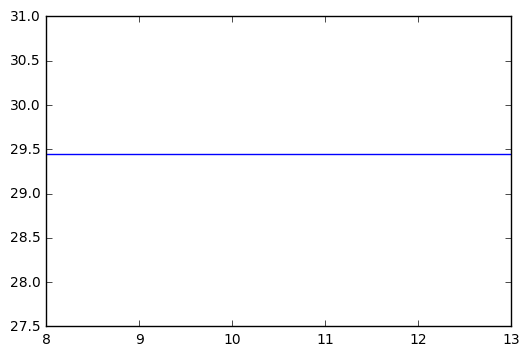

(0.0, 40)

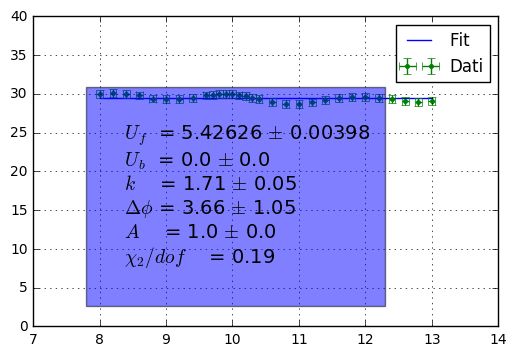

In [5]:
# importo le librerire per visualizzare i widgets
from ipywidgets import *
from IPython.display import display
%matplotlib inline

# leggo i dati
x_adattato, y_adattato = np.genfromtxt('data_adattato.txt', skip_header=1, unpack=True)

def execute_fit(x, y, sigma_x, sigma_y, fit_function, beta0, ifixb=[1,1,1,1,1]):
    # eseguo il fit dei dati usando come pesi le deviazioni standard e come parametri
    # iniziali quelli definiti nel parametro 'beta0'
    model_adattato = Model(fit_function)
    data_adattato = Data(x, y, wd=np.full( (1, np.size(x)), 1/sigma_x**2),\
            we=np.full((1, np.size(y)), 1/sigma_y**2))
    myodr = ODR(data_adattato, model_adattato, beta0=beta0, ifixb=ifixb)
    myoutput = myodr.run()

    # salvo i parametri ottenuti
    chi_2            = myoutput.sum_square
    dof              = np.size(x_adattato) - 1
    chi_2_ridotto    = round(chi_2/dof, 2)
    U_F              = round(myoutput.beta[0], 5)
    sigma_U_F        = round(myoutput.sd_beta[0], 5)
    U_B              = round(myoutput.beta[1], 5)
    sigma_U_B        = round(myoutput.sd_beta[1], 5)
    k                = round(myoutput.beta[2], 2)
    sigma_k          = round(myoutput.sd_beta[2], 2)
    delta_phi        = round(myoutput.beta[3], 2)
    sigma_delta_phi  = round(myoutput.sd_beta[3], 2)
    amplitude        = round(myoutput.beta[4], 2)
    sigma_amplitude  = round(myoutput.sd_beta[4], 2)
    parameters       = [chi_2, dof, chi_2_ridotto, U_F, sigma_U_F, U_B, 
        sigma_U_B, k, sigma_k, delta_phi, sigma_delta_phi, amplitude, 
        sigma_amplitude]

# preparo la stringa di testo da visualizzare nel grafico
parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(U_F, sigma_U_F, U_B, sigma_U_B, k, sigma_k,
          delta_phi, sigma_delta_phi, amplitude, sigma_amplitude,
          chi_2_ridotto)

# plotto i dati da manipolare e i dati reali
x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
plot_data, = ax.plot(x, y, label='Fit')

# definisco la funzione che viene chiamata quando un widget cambia valore
def manipulate(U_F, U_B, k, delta_phi, amplitude):
    x = np.linspace(8, 13, 200)
    params = [U_F, U_B, k, delta_phi, amplitude]
    plot_data.set_ydata(fit_function(params, x))
    display(fig)

# definisco i ranges, gli step e i valori iniziali dei vari parametri che voglio modificare
options = interactive(manipulate, U_F=widgets.FloatSlider(min=0,max=6,step=0.05,value=parameters[0]), 
         U_B=widgets.FloatSlider(min=0,max=6,step=0.05,value=parameters[1]), 
         k=widgets.FloatSlider(min=-10,max=180,step=5,value=parameters[2]),
         delta_phi=widgets.FloatSlider(min=-3,max=10,step=0.05,value=parameters[3]), 
         amplitude=widgets.FloatSlider(min=0,max=2,step=0.02,value=parameters[4]))
display(options)


# definisco la funzione che viene chiamata quando il bottone viene cliccato
def handle_fit(obj):
    params = [obj.data['params']]
    execute_fit(obj.data['x'], 
                obj.data['y'], 
                obj.data['sigma_x'], 
                obj.data['sigma_y'], 
                obj.data['fit_function'], 
                params)
    print(obj.data)
    
# impacchettizzo tutti i dati per poter eseguire un fit completo 
data = {
    'x': x_adattato,
    'y': y_adattato,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'fit_function': fit_function,
    'params': options.kwargs
    #'ifixb': [0, 0, 0, 1, 1]
}

# giusto perchè siamo belli aggiungiamo un bottone che quando viene schiacciato
# riesegue il fit utilizzando i parametri impostati
'''
fit_button = widgets.Button(description="Fit this function", data=data)
display(fit_button)
fit_button.on_click(handle_fit)
'''

# plotto i dati reali con le loro incertezze
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(8, 5, parameters_text, size=14,
        bbox={ 'alpha':0.5, 'pad':10})
ax.grid()
ax.legend()
ax.set_ylim(0., 40)